In [1]:
import numpy as np
from scipy.io.wavfile import write
from scipy.special import expit
from scipy.signal import hilbert

import matplotlib.pyplot as plt

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

In [3]:
import ipywidgets as widgets

In [4]:
def calculate_envelope(signal):
    # Hilbert transform - obwiednia amplitudowa
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    return envelope

def normalize_to_flat_envelope(signal, envelope, target_value=1):
    """
    Normalizuje sygnał tak, aby jego obwiednia była stałą linią prostą o wartości target_value.
    """
    normalized_signal = (signal / envelope) * target_value
    normalized_signal = np.nan_to_num(normalized_signal)
    return normalized_signal

In [5]:
def generate_sound(signal, num_samples, attack_duration, release_duration, slope_attack, slope_release, sr = 44100):
    duration = num_samples / sr
    time = np.linspace(0, duration, num_samples)
    
    # Create modified envelope with slope parameter
    attack = expit((time - attack_duration / 2) * slope_attack / attack_duration)
    release = expit((duration - time - release_duration / 2) * slope_release / release_duration)
    
    envelope = attack * release
    
    modulated_noise = signal * envelope
    modulated_noise = modulated_noise / np.max(np.abs(modulated_noise))

    return modulated_noise, envelope, time, sr

In [6]:
def update_envelope_prep(signal, sampl_rate):
    def update_envelope(attack_duration, release_duration, attack_slope, release_slope):
        num_samples = len(signal)
        sample_rate = sampl_rate
        modulated_noise, envelope, time, sr = generate_sound(signal, num_samples, attack_duration, release_duration, attack_slope, release_slope, sr=sample_rate)
        
        fig, ax = plt.subplots(2,1, figsize=(12, 6))
        ax[0].plot(time, envelope)
        librosa.display.waveshow(modulated_noise, sr=sr, alpha=0.8, ax=ax[1])
        plt.title("Waveform")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.show()
        
        display(Audio(modulated_noise, rate=sr))
    return update_envelope

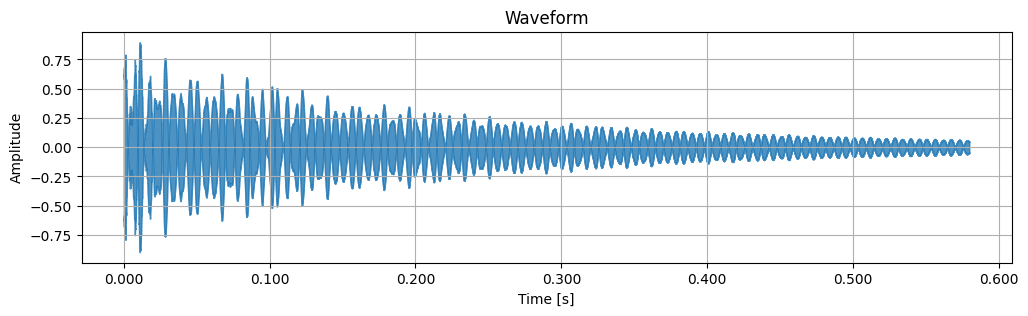

In [7]:
filename = 'drum.wav'  # Ścieżka do pliku dźwiękowego
y, sr = librosa.load(filename)

fig, ax = plt.subplots(1,1, figsize=(12, 3))
librosa.display.waveshow(y, sr=sr, alpha=0.8, ax=ax)
plt.title("Waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

display(Audio(y, rate=sr))

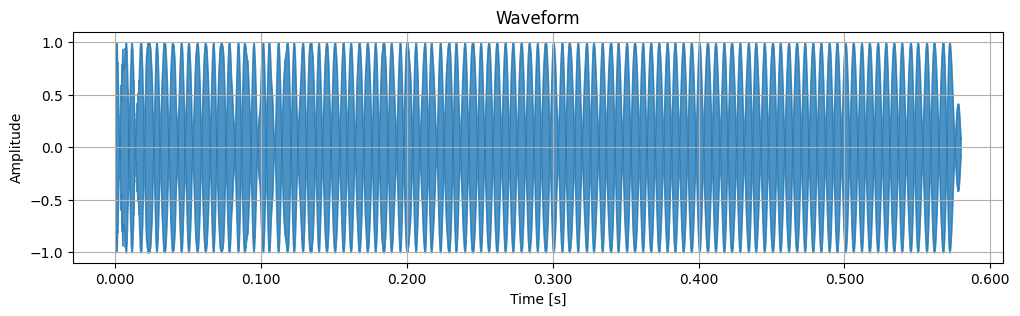

In [8]:
envelope = calculate_envelope(y)
y_normalized = normalize_to_flat_envelope(y, envelope)

fig, ax = plt.subplots(1,1, figsize=(12, 3))
librosa.display.waveshow(y_normalized, sr=sr, alpha=0.8, ax=ax)
plt.title("Waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

display(Audio(y_normalized, rate=sr))

In [9]:
attack_duration_slider = widgets.FloatSlider(value=0.01, min=0.01, max=2.0, step=0.01, description="Attack Dur:")
release_duration_slider = widgets.FloatSlider(value=0.01, min=0.01, max=2.0, step=0.01, description="Release Dur:")
attack_slope_slider = widgets.FloatSlider(value=10, min=1, max=20, step=1, description="Attack Slope:")
release_slope_slider = widgets.FloatSlider(value=10, min=1, max=20, step=1, description="Release Slope:")

# Link sliders to update function
widgets.interactive(update_envelope_prep(y_normalized, sr), 
                    attack_duration=attack_duration_slider, 
                    release_duration=release_duration_slider, 
                    attack_slope=attack_slope_slider, 
                    release_slope=release_slope_slider)

# Display sliders
output = widgets.interactive_output(
    update_envelope_prep(y_normalized, sr),
    {
        "attack_duration": attack_duration_slider,
        "release_duration": release_duration_slider,
        "attack_slope": attack_slope_slider,
        "release_slope": release_slope_slider,
    },
)

# Display sliders and output together
ui = widgets.VBox([attack_duration_slider, release_duration_slider, attack_slope_slider, release_slope_slider])
display(ui, output)

Output()